In [46]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error as mae

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal

# CVXPY
from solardatatools.signal_decompositions import make_l2_l1d2 as cvx_sd
# OSD
from solardatatools.osd_signal_decompositions import make_l2_l1d2 as osd_sd

np.random.seed(45) 
random.seed(10)

In [2]:
%load_ext autoreload
%autoreload 2

## `make_l2_l1d2`

### Create input signal

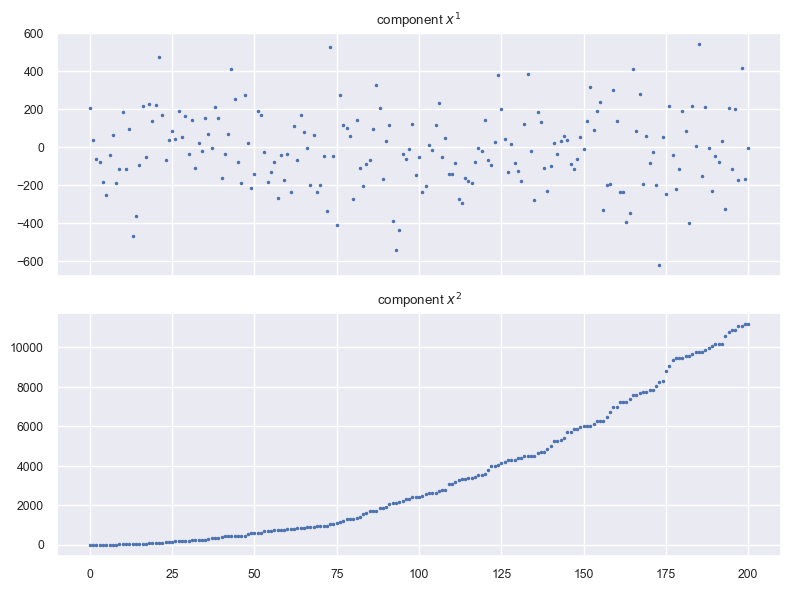

In [3]:
t = 200

# piecewise linear term
x_points = np.random.randint(low=0, high=200, size=t)
x_points.sort()
x_points = np.append(0, x_points)  # the first 0 point is 0
slopes = np.add.accumulate(np.random.random(size=t-1))
slopes = np.append(0,slopes)  # the first slope is 0
y_incr = np.ediff1d(x_points)*slopes
y_points = np.add.accumulate(y_incr)
y_points = np.append(0,y_points)  # the first y values is 0

# gaussian noise
signal1 = 200 * np.random.randn(len(y_points))

X_real = np.zeros((2, len(y_points)), dtype=float)
X_real[0] = signal1
X_real[1] = y_points

y = np.sum(X_real, axis=0)

plot_decomp(X_real)

Data with missing values

In [4]:
indices_full = list(range(len(X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, 200, replace=False)

X_real_80perc = X_real.copy()
y_80perc = y.copy()

X_real_80perc[0][indices_20perc] = np.nan
X_real_80perc[1][indices_20perc] = np.nan
y_80perc[indices_20perc] = np.nan

Data with missing chunks

In [5]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
X_real_chunks= X_real.copy()
y_chunks = y.copy()

for e in indices_chunks_start:
    for i in range(e, e+25):
        X_real_chunks[0][i] = np.nan
        X_real_chunks[1][i] = np.nan
        y_chunks[i] = np.nan

In [6]:
def cvx_sd(y, weight=300, comp_osd=None):
    
    y_hat = cvx.Variable(len(y))
    y_param = cvx.Parameter(len(y), value=y)
    mu = cvx.Parameter(nonneg=True)
    mu.value = weight
    
    error = cvx.sum_squares(y_param - y_hat)
    reg = cvx.norm(cvx.diff(y_hat, k=2), p=1)
    
    objective = cvx.Minimize(error + mu * reg)
    constraints = [y_param[0] == y_hat[0], y[-1] == y_hat[-1]]
    problem = cvx.Problem(objective, constraints)

    problem.solve(solver="MOSEK")
    
    # to get OSD scaled objective
    if comp_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        y_hat.value = comp_osd
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value
    
    return y_hat.value

In [7]:
def osd_sd(y, weight=300, solver="MOSEK"):
    
    c1 = SumSquare(weight=1)    
    c2 = Aggregate([
        SumAbs(weight=weight, diff=2), 
        FirstValEqual(y[0]),
        LastValEqual(y[-1])
                 ]) 

    classes = [c1, c2]
    
    problem = Problem(y, classes)
    problem.decompose(solver=solver)
    
    y_hat = problem.decomposition[1]
    
    return y_hat

CVXPY objective       5998470.72585
OSD objective, scaled 5998469.74306
s_seas MAE (OSD,CVX)   9.95e-04


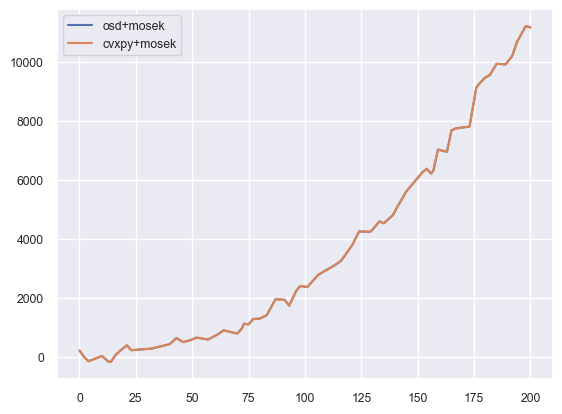

In [16]:
w_osd = {'weight' : 3e2}
w_cvx = {'weight' : 3e2}

osd_output = osd_sd(y, **w_osd, solver="MOSEK")
cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", return_obj=True)[0]

print(f's_seas MAE (OSD,CVX)   {mae(osd_output, cvxpy_output):.2e}')

f, (ax1) = plt.subplots(1, 1)
ax1.plot(osd_output, label="osd+mosek")
ax1.plot(cvxpy_output, label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax1.legend();

In [47]:
w_osd = {'weight' : 3e2}
w_cvx = {'weight' : 3e2}

#osd_output = osd_sd(y_80perc, **w_osd, solver="MOSEK")
#cvxpy_output = cvx_sd(y_80perc, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y_80perc, **w_cvx, solver="MOSEK", return_obj=True)[0]

print(f's_seas MAE (OSD,CVX)   {mae(osd_output, cvxpy_output):.2e}')

f, (ax1) = plt.subplots(1, 1)
ax1.plot(osd_output, label="osd+mosek")
ax1.plot(cvxpy_output, label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax1.legend();

Error: rescode.err_nan_in_c(1470): The objective vector c contains an invalid value for variable '' (0).